In [1]:
%load_ext autoreload
%autoreload 2

# These importing lines pull in the Recommender_Lib from folders above this file
from DataAugmentation_Lib import *

# These importing lines pull in env installed libs
import json
import pandas as pd
import numpy as np

In [2]:
# First, make sure the data we want exists. If not, download from google drive
R_Lib.verify_raw_data_exists()
movies_df, users_df, ratings_df = R_Lib.read_raw_data()

In [4]:
movies_df.describe()

,movieId
count,62967.000000
mean,122989.599092
std,63527.601173
min,1.000000
25%,82916.000000
50%,138719.000000
75%,174066.000000
max,213111.000000


In [5]:
users_df.describe()

,userId,gender,age,occupation,zip-code
count,168581.000000,168581.000000,168581.000000,168581.000000,1.685810e+05
mean,84291.000000,-0.979725,1.097757,0.291889,3.138246e+03
std,48665.287202,0.200348,6.195732,1.930790,4.707669e+05
min,1.000000,-1.000000,0.000000,0.000000,0.000000e+00
25%,42146.000000,-1.000000,0.000000,0.000000,0.000000e+00
50%,84291.000000,-1.000000,0.000000,0.000000,0.000000e+00
75%,126436.000000,-1.000000,0.000000,0.000000,0.000000e+00
max,168581.000000,1.000000,56.000000,20.000000,1.931220e+08


array([[<AxesSubplot: title={'center': 'gender'}>]], dtype=object)

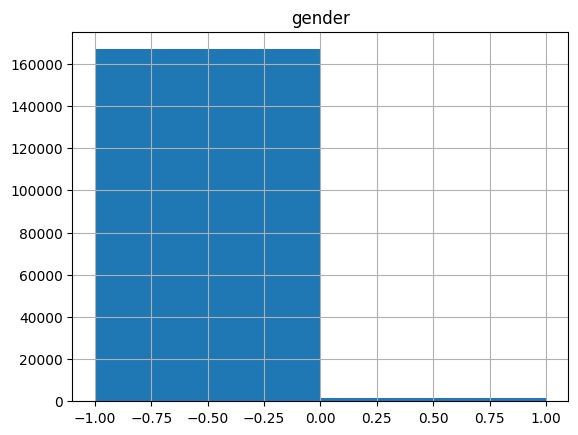

In [10]:
# Can see that it is mostlty males who gave ratings (-1=M, 1=F)
users_df.hist(column=R_Lib.MOVIE_LENS_1M_GENDER_COL, bins=2)

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

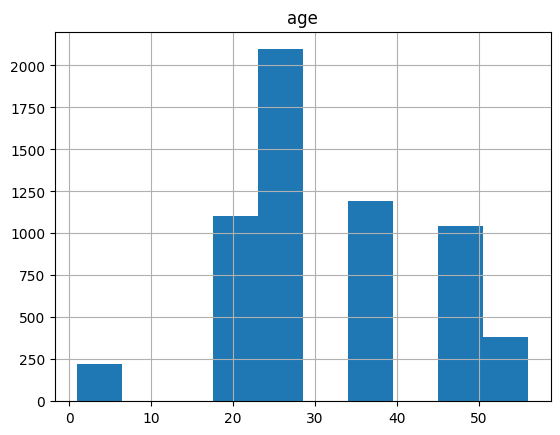

In [14]:
# Can see that it is mostly the 18 - 35 year old users
users_df[users_df[R_Lib.MOVIE_LENS_1M_AGE_COL] > 0].hist(column=R_Lib.MOVIE_LENS_1M_AGE_COL)

array([[<AxesSubplot: title={'center': 'occupation'}>]], dtype=object)

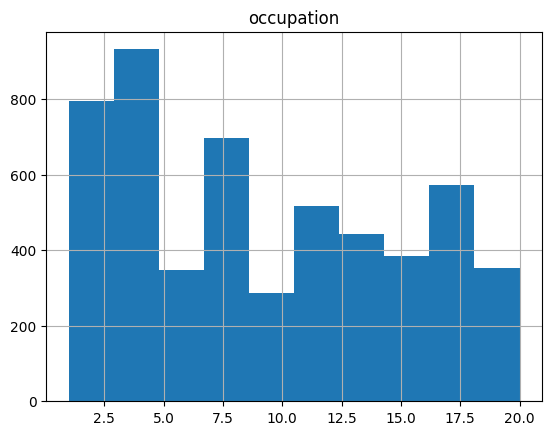

In [16]:
# Can see that the most reported occupations are academic, artist, clerical/admin, college/gra student
users_df[users_df[R_Lib.MOVIE_LENS_1M_OCCUPATION_COL] > 0].hist(column=R_Lib.MOVIE_LENS_1M_OCCUPATION_COL)

In [6]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,2.600030e+07,2.600030e+07,2.600030e+07,2.600030e+07
mean,8.443516e+04,2.868360e+04,3.535690e+00,1.206240e+09
std,4.866921e+04,5.298928e+04,1.063007e+00,2.273518e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.212700e+04,1.208000e+03,3.000000e+00,9.926134e+08
50%,8.417200e+04,3.108000e+03,4.000000e+00,1.180298e+09
75%,1.266020e+05,3.316200e+04,4.000000e+00,1.444533e+09
max,1.685810e+05,2.131230e+05,5.000000e+00,1.574328e+09


array([[<AxesSubplot: title={'center': 'rating'}>]], dtype=object)

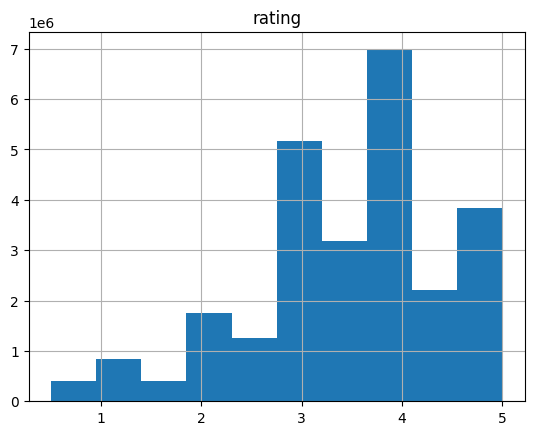

In [9]:
# Most ratings are 4
ratings_df.hist(column=R_Lib.MOVIE_LENS_25M_RATING_COL)

array([[<AxesSubplot: title={'center': 'userId'}>]], dtype=object)

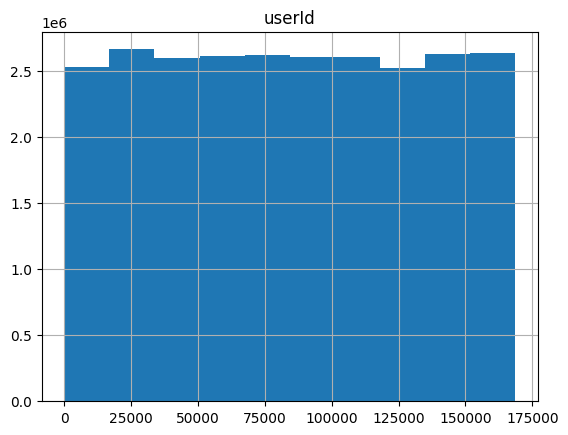

In [18]:
# Can see there is about the same amount of ratings for each of those who gave ratings.
ratings_df.hist(column=R_Lib.MOVIE_LENS_25M_USER_ID_COL)

In [ ]:
'''
users_df comes back ready for being saved as a matrix, so save as a numpy.
'''
np.savez(R_Lib.PATH_TO_PROCESSED_USERS_DATA, users_matrix=users_df.to_numpy(dtype=np.int32))

In [3]:
'''
Define some variables that will help us load stuff later and make decisions below
'''
total_users = users_df.shape[0]
total_movies = movies_df.shape[0]
reindexer = np.arange(1, total_users+1)
'''
Give a function to the SparseMatrixMaker to check for bad data so that if the ratings
data matrix gets outof the range of the ratings numbers, 0.0 - 5.0, then an exception
will throw, because something is broken.
'''
sparse_mat_maker = SparseMatrixMaker(bad_data_detector=(True, lambda d: d < 0.0 or d > 5.0))
print("Total users: ", total_users, "\nTotal movies: ", total_movies)

Sparse row count =  0  and sparse col count =  0
Total users:  168581 
Total movies:  62967


In [ ]:
'''
Now we have 3 DFs, two of which correspond to user ratings: users_df, ratings_df. Lets combine them.
We have movies_df, which has all the movie IDs, so make a column for each movie ID to users_df
and include the rating if the user has rated it.
It takes awhile to run, longer if you give it a quiet=False so that it reports progress
to not appear stlled. After, save the sparse coords and data as a numpy.
'''
# The store_ratings_for_mov_id_as_sparse_coords method builds a sparse matrix
# coordinates into 3 long arrays and those are saved to be loaded in later.
# store_ratings_for_mov_id_as_sparse_coords just returns the movie_id it is given.
movie_ids_series = movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_ID_COL].map(
    lambda movie_id: sparse_mat_maker.store_ratings_for_mov_id_as_sparse_coords(
        movie_id,
        ratings_df,
        reindexer,
        quiet=True))

sparse_mat_maker.save_sparse_mat_coords(R_Lib.PATH_TO_PROCESSED_RATINGS_DATA)
print("Finshed and saved ratings matrix.")

In [4]:
'''
Iterate over the genres of each movie and get a one-hot encoding representation,
then make it into a DF and concat the results to the end of the DF with the movie titles
'''
movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_GENRES_COL] = movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_GENRES_COL].map(
    lambda gs: R_Lib.genres_to_one_hot(gs, '|', R_Lib.MOVIE_LENS_GENRES))

In [5]:
''''
The movie titles have years tacked on the ends of them, with some parenths.
Take these off, then insert them as their own column of "numbers" for the matrix
of numbers we are building.
'''
year_accumulator = []
movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_TITLE_COL] = movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_TITLE_COL].apply(
    lambda title: accumulate_year(year_accumulator, title))
movies_df = pd.concat(
    [movies_df, pd.DataFrame({YEAR_COL: year_accumulator})],
    axis=1,
    join="inner")

'''
Found some bad chars in the year column of our movies_df.
Filter these out manually so we have just a column of strings that can be converted to ints without issue.
'''
movies_df[YEAR_COL] = movies_df[YEAR_COL].map(lambda year: year.replace("L'Associe", ""))
movies_df[YEAR_COL] = movies_df[YEAR_COL].map(lambda year: year.replace(')', ""))
movies_df[YEAR_COL] = movies_df[YEAR_COL].map(lambda year: year.replace('(', ""))
movies_df[YEAR_COL] = movies_df[YEAR_COL].map(lambda year: year.split('-')[0])
movies_df[YEAR_COL] = movies_df[YEAR_COL].map(lambda year: year.split('–')[0])

In [6]:
'''
Now we have to do some word embedding. Make a glove that was trained on Twitter object.
First, make sure the data we want exists. If not, download from google drive.
'''
R_Lib.verify_glove_data_exists()
embedded_vector_len = 25 # There is 25, 50, 100, 200
glove = R_Lib.Glove(R_Lib.PATH_TO_GLOVE, embedded_vector_len)

In [7]:
'''
Now, need to inspect the tags, clean them so that they are only words seperated by spaces.
Then, either throw out duplicate movie ID tags or combine all tags that are for the same movie id. 
Then find the tag with the most words and call that the number of vectors we need to make for each movie.
'''
tags_df = pd.read_csv(R_Lib.PATH_TO_MOVIE_LENS_25M_TAGS)
tags_df[MOVIE_LENS_25M_TAG_COL] = tags_df[MOVIE_LENS_25M_TAG_COL].map(glove.clean_str)
tags_df = tags_df.drop_duplicates(subset=[R_Lib.MOVIE_LENS_25M_MOVIE_ID_COL])

In [8]:
'''
Find that there are some really long tags. Need to make an equal number of vectors for each movie.
'''
glove_vects_per_movie = tags_df[MOVIE_LENS_25M_TAG_COL].map(lambda tag: len(tag.split())).unique()
glove_vects_per_movie

array([ 1,  2,  4,  3,  9,  6,  5, 15,  7, 16, 10,  8])

In [9]:
'''
Make a version of the tags where even movies without tags have a row that is just the empty string
'''
movie_id_reindexer = movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_ID_COL].to_numpy()
tags_df_mut = tags_df.set_index(R_Lib.MOVIE_LENS_25M_MOVIE_ID_COL)
tags_df_mut = tags_df_mut.reindex(movie_id_reindexer, fill_value="")

In [10]:
'''
Don't want to make so many glove embeddings, so will only embed the first certain number
of tokens for those movies with tags.
Embed the tag for each movie. Some of this is just embedding "", which will
return an embedding of all 0s.
'''
num_of_toks_to_embed = 6
embedded_col = tags_df_mut[MOVIE_LENS_25M_TAG_COL].map(lambda tag: glove.embed_str(tag, num_of_toks_to_embed))

In [11]:
'''
Tack it onto the end of the movies_df
'''
movies_df = movies_df.set_index(R_Lib.MOVIE_LENS_25M_MOVIE_ID_COL)
movies_df = movies_df.join(embedded_col)

In [12]:
'''
Now clean and embed the movie titles
'''
movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_TITLE_COL] = movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_TITLE_COL].map(
    glove.clean_str).map(lambda title: glove.embed_str(title, num_of_toks_to_embed))

In [13]:
'''
Now we can see it is all numbers.
'''
movies_df = movies_df.reset_index()
movies_df

,movieId,title,genres,year,tag
0,1,"[[-0.5956, -0.67774, 0.63825, -0.55081, 0.3310...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1995,"[[-0.16845, 0.39337, 0.24115, -1.2381, 0.06361..."
1,2,"[[0.10984, -0.72454, 1.212, -0.16188, -0.77879...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1995,"[[-0.36034, -0.16173, 0.52871, 0.1684, -1.0275..."
2,3,"[[-0.63078, 0.23414, 1.0839, -0.4605, 0.36985,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1995,"[[0.42466, -0.23493, 0.67394, -0.51295, 0.6706..."
3,4,"[[-0.94693, 1.202, 0.68523, -0.13582, -0.76029...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",1995,"[[0.57621, -0.0097165, -0.8488, -0.4566, 0.643..."
4,5,"[[-1.2006, 0.59454, 0.27821, 0.86424, 0.021296...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1995,"[[-0.86323, -0.13674, -1.2718, 0.67397, 1.0864..."
...,...,...,...,...,...
62962,213101,"[[-0.95787, -1.298, 0.021577, 0.48332, 0.71122...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1954,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
62963,213106,"[[-0.95826, 0.34048, 0.51397, -0.22547, -0.069...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1973,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
62964,213107,"[[-0.42776, -0.097852, 0.54833, 0.20915, -0.18...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1943,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
62965,213110,"[[-1.9711, 0.44933, 0.57468, 0.39935, -0.04219...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1987,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
'''
Want to map over all movies rows and turn that into a row in sparse matrix, then save
'''
sparse_mat_maker.reset((True, lambda x: x == np.inf))
movie_ids_series = movies_df.apply(
    lambda series: sparse_mat_maker.make_movies_df_row_element_into_sparse_coords(series, quiet=True),
    axis=1)
sparse_mat_maker.save_sparse_mat_coords(R_Lib.PATH_TO_PROCESSED_MOVIES_DATA)

'''
Now there are 3 matrices:
movies.npz, ratings.npz, users.npz
movies.npz and ratings.nps are saved in sparse matrix format while users is not.
'''

In [28]:
'''
Will need to know some of the stuff we have here out in the other files where we load
in the matrices, so save that all here to a specs json.
'''
num_columns_embedded = 2
num_cols_one_encoded = 1
movie_mat_col_cnt = (
    len(movies_df.columns) - num_columns_embedded - num_cols_one_encoded) + (
        (num_columns_embedded*(embedded_vector_len*num_of_toks_to_embed)) + R_Lib.MOVIE_LENS_NUM_GENRES)
with open(R_Lib.PATH_TO_PROCESSED_DATA_SPECS, "w") as out_file:
    out_file.write(
        json.dumps(
            {
                R_Lib.SPEC_MOVIE_IDS: movies_df[R_Lib.MOVIE_LENS_25M_MOVIE_ID_COL].to_list(),
                R_Lib.SPEC_USER_IDS: users_df[R_Lib.MOVIE_LENS_25M_USER_ID_COL].to_list(),
                R_Lib.SPEC_MOVIES_MATRIX_COLUMN_COUNT: movie_mat_col_cnt,
                R_Lib.SPEC_NUM_TOKS_EMBEDDED: num_of_toks_to_embed,
                R_Lib.SPEC_EMBEDDING_LEN: embedded_vector_len
            },
            indent=4))